In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import pylab

%matplotlib inline
pylab.rcParams["figure.figsize"] = (10.,10.)

# StackImages Function to print images on the same page

In [2]:
def stackImages(scale,imgArray):
    rows = len(imgArray)
    cols = len(imgArray[0])
    rowsAvailable = isinstance(imgArray[0], list)
    width = imgArray[0][0].shape[1]
    height = imgArray[0][0].shape[0]
    if rowsAvailable:
        for x in range ( 0, rows):
            for y in range(0, cols):
                if imgArray[x][y].shape[:2] == imgArray[0][0].shape [:2]:
                    imgArray[x][y] = cv2.resize(imgArray[x][y], (0, 0), None, scale, scale)
                else:
                    imgArray[x][y] = cv2.resize(imgArray[x][y], (imgArray[0][0].shape[1], imgArray[0][0].shape[0]), None, scale, scale)
                if len(imgArray[x][y].shape) == 2: imgArray[x][y]= cv2.cvtColor( imgArray[x][y], cv2.COLOR_GRAY2BGR)
        imageBlank = np.zeros((height, width, 3), np.uint8)
        hor = [imageBlank]*rows
        hor_con = [imageBlank]*rows
        for x in range(0, rows):
            hor[x] = np.hstack(imgArray[x])
        ver = np.vstack(hor)
    else:
        for x in range(0, rows):
            if imgArray[x].shape[:2] == imgArray[0].shape[:2]:
                imgArray[x] = cv2.resize(imgArray[x], (0, 0), None, scale, scale)
            else:
                imgArray[x] = cv2.resize(imgArray[x], (imgArray[0].shape[1], imgArray[0].shape[0]), None,scale, scale)
            if len(imgArray[x].shape) == 2: imgArray[x] = cv2.cvtColor(imgArray[x], cv2.COLOR_GRAY2BGR)
        hor= np.hstack(imgArray)
        ver = hor
    return ver

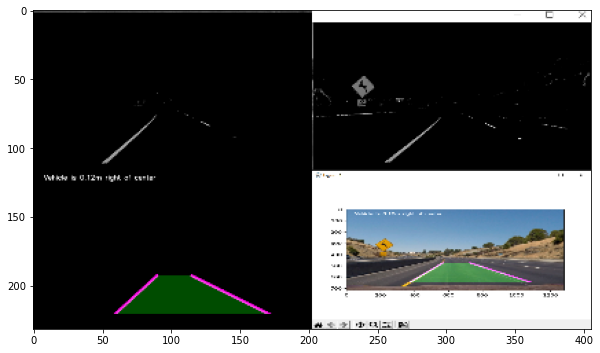

In [3]:
img1 = cv2.imread("region.jpg")
img2 = cv2.imread("edges.jpg")
img3 = cv2.imread("display lines.jpg")
img4 = cv2.imread("output2.jpg")
imgstack = stackImages(0.4,([img1, img2],
                            [img3, img4]))
imgstack = cv2.cvtColor(imgstack,cv2.COLOR_BGR2RGB)
plt.imshow(imgstack)

# Region function to determine region of interest

In [22]:
def region(image):
    height, width = image.shape
    region_of_interest = np.array([[(100, height), (550, 350), (1200, height)]]) #defines a triangle as a region that surrounds the lanes
    mask = np.zeros_like(image)  # black image mask
    mask = cv2.fillPoly(mask, region_of_interest, 255)  # Fill the triangle white
    #image is image number 3
    mask = cv2.bitwise_and(image, mask)  # detect the lane lines exactly
    #mask is image number 4
    return mask


ValueError: too many values to unpack (expected 2)

# Function to average hough lines

In [18]:
def average(image, lines):
    right = []
    left = []
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)                  #line's start and end points
        parameters = np.polyfit((x1, x2), (y1, y2), 1)    #put the coordinates of the start and end points in parameters array
        m = parameters[0]
        c = parameters[1]
        if m < 0:
            left.append((m, c))                             #identify as a left line
        else:
            right.append((m, c))                            #identify as a right line

    right_avg = np.average(right, axis=0)
    left_avg = np.average(left, axis=0)
    left_line = connectPoints(image, left_avg)                #averages the group of left lines to one left line and the same for the group of right lines
    right_line = connectPoints(image, right_avg)
    return np.array([left_line, right_line])

# Function to detect edges

In [19]:
def edge_detection(img, gray_img):
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_yellow = np.array([20, 100, 100], dtype="uint8")          #ranges of the color yellow
    upper_yellow = np.array([100, 255, 255], dtype="uint8")
    yellow_mask = cv2.inRange(hsv_img, lower_yellow, upper_yellow)  #show only yellow and the rest is black
    white_mask = cv2.inRange(gray_img, 200, 255)                    #show only white and the rest is black
    yw_mask = cv2.bitwise_or(white_mask, yellow_mask)               #detects yellow and white colors;the yellow color in the yellow_mask is white
    edges = cv2.bitwise_and(gray_img, yw_mask)                      #detects the white edges
    return edges

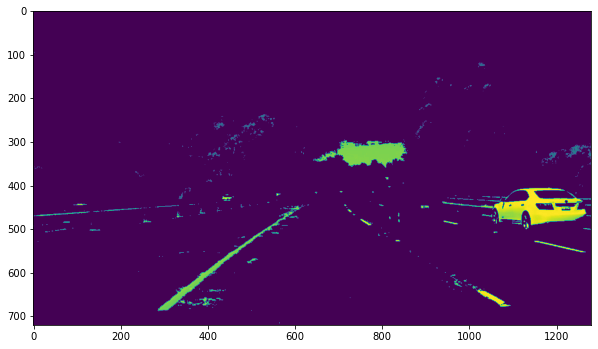

In [30]:
img1 = cv2.imread("test1.jpg")
img2 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
img3 = edge_detection(img1, img2)
#img3 = cv2.cvtColor(img3,cv2.COLOR_BGR2RGB)

plt.imshow(img3)

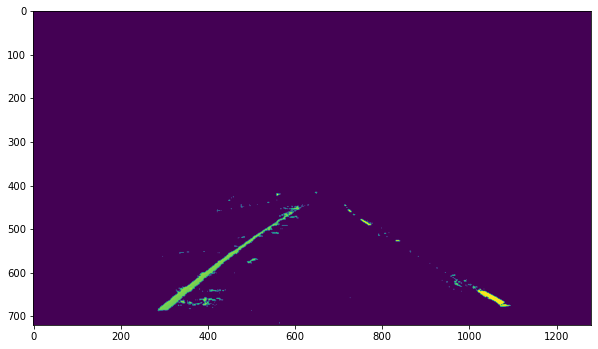

In [31]:
#regionimg = cv2.imread("test1.jpg")
regionimg = region(img3)
#regionimg = cv2.cvtColor(regionimg, cv2.COLOR_BGR2RGB)

plt.imshow(regionimg)

# Function to connect points

In [9]:
#y=mx+c  straight line equation
def connectPoints(image, average):                                  #function to make a line
    try:
        m, c = average                                              #updates the value of m,c according the average line
    except TypeError:
        m, c = 0.001, 0                                             #error if the line is nearly horizontal
    y1 = int(image.shape[0])
    y2 = int(y1 * (3.3 / 5))
    x1 = int((y1 - c) // m)                                         #the height (y) remains the same, but x changes
    x2 = int((y2 - c) // m)
    return np.array([x1, y1, x2, y2])

# Function to display lines and fill between them

In [10]:
def display_lines(image, lines):                                        #lines: the one average left line and the one average right line
    lines_image = np.zeros_like(image, 'uint8')
    poly_image = np.zeros_like(image, 'uint8')
    points = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line                                                                       #a line has 2 endpoints (x1,y1), (x2,y2)
            cv2.line(lines_image, (int(x1), int(y1)), (int(x2), int(y2)), (235, 0, 255), 12)            # draw the lines on the black lines_image


            if x1 < x2:
                points.append([x1, y1])                                             #the left road line
                points.append([x2, y2])
            else:
                points.append([x2, y2])
                points.append([x1, y1])                                             #the right road line

    points = np.array(points)
    cv2.fillPoly(poly_image, [points], (0, 255, 0))             #fill space between the lines with green color; draw the green polygon on the black poly_image
    cv2.addWeighted(poly_image, 0.3, lines_image, 1, 0, lines_image)   #combine the drawn lines and green polygon in one image

    # Measure distance from center
    realCenter_x_axis = image.shape[1] / 2                                          #width/2; which resembles the car/camera center
    laneCenter_x_axis = points[0][0] + (points[-1][0] - points[0][0]) / 2
    centerDifference = realCenter_x_axis - laneCenter_x_axis

    if centerDifference > 0:
        text = f"Vehicle is {abs(round(float(centerDifference / 1000), 2))}m left of center"
    elif centerDifference < 0:
        text = f"Vehicle is {abs(round(float(centerDifference / 1000), 2))}m right of center"
    else:
        text = f"Vehicle is at the center of the lane"


    lines_image = cv2.putText(lines_image, text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    #  Crop car engine hood
    lines_image = cv2.rectangle(lines_image, (0, image.shape[0] - 75), (image.shape[1], image.shape[0]), (0, 0, 0), -1)

    return lines_image              # image number 5

# Main Function that calls all other functions and returns output

In [12]:
def framePipeline(img):

    # Convert to Grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)     #image number 1

    # Add Gaussian blur
    blurred_img = cv2.GaussianBlur(gray_img, (5, 5), 0)  #image number 2

    # Edges Detection
    edges = edge_detection(img, gray_img)                #image number 3

    # Exact Lines Detection
    exactLanes = region(edges)                       #image number 4

    # Hough lines processing
    lines = cv2.HoughLinesP(exactLanes, 1, np.pi / 180, 35, np.array([]), minLineLength=25, maxLineGap=2)
    averagedLines = average(img, lines)               #the one average line for each side; total is 2 lines (the lane)
    blackLines = display_lines(img, averagedLines)    #image number 5

    blankImg= np.zeros_like(img)
    imgStack= stackImages(0.4,([gray_img,blurred_img,edges],
                               [exactLanes,blackLines,blankImg]))
    cv2.imshow('pipeline',imgStack)

    lanes = cv2.addWeighted(img, 1, blackLines, 1, 1)
    return lanes                                       #the final output of the pipeline

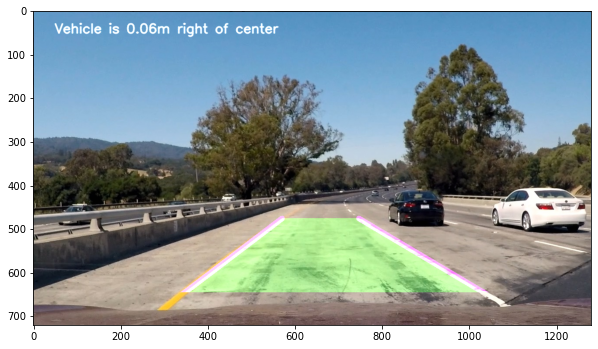

In [13]:
output = cv2.imread("test1.jpg")
output = framePipeline(output)
output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

plt.imshow(output)